<h1>Supervised transfer learning on fall detection data</h1>

# Table of contents
1. [Supervised random forest transfer learning on balanced dataset](#balanced)
    1. [Transfer algorithms comparison and aggregation](#comp_b)
    2. [Transferred trees visualization](#vis_b)
2. [Supervised random forest transfer learning on imbalanced dataset](#imbalanced)
    1. [Transfer algorithms comparison and aggregation](#comp_i)
    2. [Transferred trees visualization](#vis_i)
    3. [Transfer algorithms adaptation for class imbalance](#alg_imb)


In [35]:
import sys
import copy
import pandas as pd
import  numpy as np
import sklearn.metrics as metr
import sklearn.model_selection as select
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import copy

In [36]:
#!pip install adapt
import adapt._tree_utils as ut
from adapt.parameter_based import TransferTreeClassifier, TransferForestClassifier
from adapt.parameter_based import TransferTreeSelector, TransferForestSelector

<h2>Supervised random forest transfer learning on balanced dataset</h2><a name="balanced"></a>

In [90]:
path_save = ''

name_bdd_sim = 'fall_det_sim'
name_bdd_real = 'fall_det_real_balanced'

X_source = pd.read_csv(path_save+name_bdd_sim+'_feats.csv',dtype='float64').iloc[:,1:]
Y_source = pd.read_csv(path_save+name_bdd_sim+'_labels.csv',dtype='int64').iloc[:,1]

X_target = pd.read_csv(path_save+name_bdd_real+'_feats.csv',dtype='float64').iloc[:,1:]
Y_target = pd.read_csv(path_save+name_bdd_real+'_labels.csv',dtype='int64').iloc[:,1]

X_source = np.array(X_source)
Y_source = np.array(Y_source)
X_target = np.array(X_target)
Y_target = np.array(Y_target)

print('Target data size :',X_target.shape[0])
print('Ratio of fall events :',sum(Y_target)/Y_target.size)

Target data size : 246
Ratio of fall events : 0.6788617886178862
[ 1.3399529e+06  6.4443677e+02 -2.5718646e+02 -3.7339794e+01
  1.2500000e+00] [ 9.5387384e+07  1.5509459e+03 -5.7977637e+02 -5.7977637e+02
  4.1000000e-01]


In [39]:
DT_only = False

K_FOLD = 10
MAX = 5
RF_SIZE = 10

# Source classifier
if DT_only:
    clf_source = DecisionTreeClassifier(max_depth=MAX)
    clf_target = DecisionTreeClassifier(max_depth=MAX)
else:
    clf_source = RandomForestClassifier(n_estimators=RF_SIZE,max_depth=MAX)
    clf_target = RandomForestClassifier(n_estimators=RF_SIZE,max_depth=MAX)

In [40]:
np.random.seed(0)

skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

auc_score_src = np.zeros(K_FOLD)
auc_score_src_tgt = np.zeros(K_FOLD)
auc_score_tgt_src = np.zeros(K_FOLD)
auc_score_tgt = np.zeros(K_FOLD)

tpr_roc_src = np.zeros(K_FOLD,dtype=object)
tpr_roc_tgt = np.zeros(K_FOLD,dtype=object)
tpr_roc_src_tgt = np.zeros(K_FOLD,dtype=object)
tpr_roc_tgt_src = np.zeros(K_FOLD,dtype=object)
fpr_roc_src = np.zeros(K_FOLD,dtype=object)
fpr_roc_tgt = np.zeros(K_FOLD,dtype=object)
fpr_roc_src_tgt = np.zeros(K_FOLD,dtype=object)
fpr_roc_tgt_src = np.zeros(K_FOLD,dtype=object)
th_roc_src = np.zeros(K_FOLD,dtype=object)
th_roc_tgt = np.zeros(K_FOLD,dtype=object)
th_roc_src_tgt = np.zeros(K_FOLD,dtype=object)
th_roc_tgt_src = np.zeros(K_FOLD,dtype=object)


k=0
for train, test in skf.split(X_source, Y_source):
    X_src_train, Y_src_train, X_src_test, Y_src_test = X_source[train], Y_source[train], X_source[test], Y_source[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(X_target, Y_target)
    auc_score_src[k] = metr.roc_auc_score(Y_src_test,clf_source.predict_proba(X_src_test)[:,1])
    auc_score_src_tgt[k] = metr.roc_auc_score(Y_target,clf_source.predict_proba(X_target)[:,1])
    
    fpr_roc_src[k],tpr_roc_src[k],th_roc_src[k] = metr.roc_curve(Y_src_test,clf_source.predict_proba(X_src_test)[:,1])
    fpr_roc_src_tgt[k],tpr_roc_src_tgt[k],th_roc_src_tgt[k] = metr.roc_curve(Y_target,clf_source.predict_proba(X_target)[:,1])
    
    k+=1

k=0
for train, test in skf.split(X_target, Y_target):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[train], Y_target[train], X_target[test], Y_target[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(X_source, Y_source)
    auc_score_tgt[k] = metr.roc_auc_score(Y_tgt_test,clf_target.predict_proba(X_tgt_test)[:,1])
    auc_score_tgt_src[k] = metr.roc_auc_score(Y_source,clf_target.predict_proba(X_source)[:,1])
    
    fpr_roc_tgt[k],tpr_roc_tgt[k],th_roc_tgt[k] = metr.roc_curve(Y_tgt_test,clf_target.predict_proba(X_tgt_test)[:,1])
    fpr_roc_tgt_src[k],tpr_roc_tgt_src[k],th_roc_tgt_src[k]  = metr.roc_curve(Y_source,clf_target.predict_proba(X_source)[:,1])
 
    k+=1
    
print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

print('ROC AUC Target model: {:.3f}'.format(np.mean(auc_score_tgt)))
print('ROC AUC Source model: {:.3f}'.format(np.mean(auc_score_src)))
print('ROC AUC Source model on Target: {:.3f}'.format(np.mean(auc_score_src_tgt)))
print('ROC AUC Target model on Source: {:.3f}'.format(np.mean(auc_score_tgt_src)))

Score Target model: 0.911
Score Source model: 0.921
Score Source model on Target: 0.841
Score Target model on Source: 0.602
ROC AUC Target model: 0.956
ROC AUC Source model: 0.962
ROC AUC Source model on Target: 0.896
ROC AUC Target model on Source: 0.752


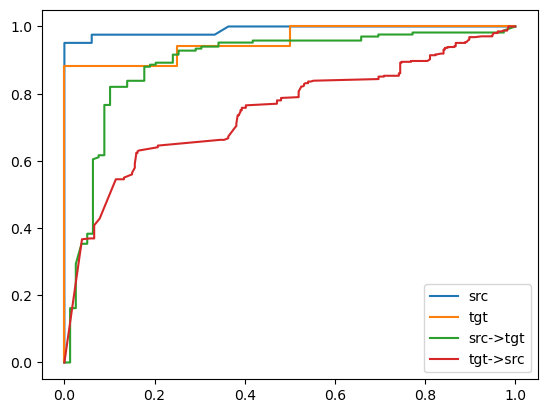

In [41]:
ind_k_fold = 5
plt.plot(fpr_roc_src[ind_k_fold],tpr_roc_src[ind_k_fold],label='src')
plt.plot(fpr_roc_tgt[ind_k_fold],tpr_roc_tgt[ind_k_fold],label='tgt')
plt.plot(fpr_roc_src_tgt[ind_k_fold],tpr_roc_src_tgt[ind_k_fold],label='src->tgt')
plt.plot(fpr_roc_tgt_src[ind_k_fold],tpr_roc_tgt_src[ind_k_fold],label='tgt->src')
plt.legend()

<h3>Transfer algorithms comparison and aggregation</h3><a name="comp_b"></a>

In [42]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(X_target, Y_target):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[train], Y_target[train], X_target[test], Y_target[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test) 
         
        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 
        
        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(Y_source,TFS.STRF_model.estimator_.predict_proba(X_source)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(Y_source,strut_model.estimator_.predict_proba(X_source)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(Y_source,ser_model.estimator_.predict_proba(X_source)[:,1])
        
        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE  
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.8986666666666666
    SER 0.906
    STRF 0.9105000000000001
AUC SCORES:
    STRUT 0.9630252100840335
    SER 0.9626542804621849
    STRF 0.9823726365546218
AUC SCORES ON SRC:
    STRUT 0.8757520356542361
    SER 0.6942906231414788
    STRF 0.8775909160994735


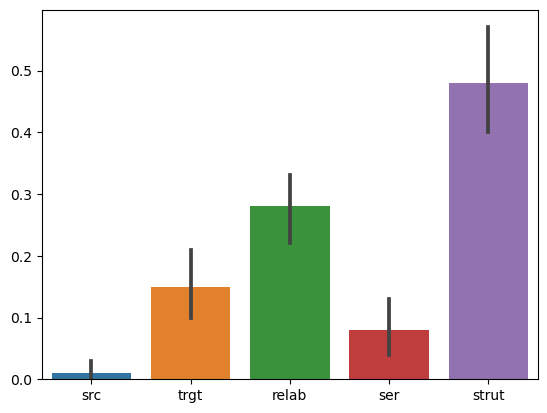

In [43]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

<h2>Transferred trees visualization</h2><a name="vis_b"></a>

In [44]:
from sklearn.tree import export_graphviz as exp_draw
from matplotlib import image
import subprocess
import os

from tree_plot_utils import TreeDot, highlight_different_nodes, count_leaves_dt, count_leaves

your_path = './img/fall_det/balanced/'

for k in range(RF_SIZE):
    file_out = exp_draw(clf_source.estimators_[k],out_file=your_path+str(k)+'_tree_src.dot',filled=True,impurity=False)
    file_out = exp_draw(ser_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_ser.dot',filled=True,impurity=False)
    file_out = exp_draw(strut_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_strut.dot',filled=True,impurity=False)


    os.system('dot -Tpng '+your_path+str(k)+'_tree_src.dot -o '+your_path+str(k)+'_tree_src.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser.dot -o '+your_path+str(k)+'_tree_ser.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut.dot -o '+your_path+str(k)+'_tree_strut.png')

    tree_img = image.imread(your_path+str(k)+'_tree_src.png')
    tree_ser_img = image.imread(your_path+str(k)+'_tree_ser.png')
    tree_strut_img = image.imread(your_path+str(k)+'_tree_strut.png')

    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)
    T_D_ser = TreeDot(str(k)+'_tree_ser.dot',your_path)
    T_D_strut = TreeDot(str(k)+'_tree_strut.dot',your_path)

    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],ser_model.estimator_.estimators_[k],0,0)


    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated.dot')

    T_D_ser._change_color(l2,'red','color',out_file=str(k)+'_tree_ser_updated.dot')
    T_D_ser = TreeDot(str(k)+'_tree_ser_updated.dot',your_path)
    T_D_ser._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_ser_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated.dot -o '+your_path+str(k)+'_tree_src_h.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser_updated.dot -o '+your_path+str(k)+'_tree_ser_h.png')

    tree_src = image.imread(your_path+str(k)+'_tree_src_h.png')
    tree_ser = image.imread(your_path+str(k)+'_tree_ser_h.png')

    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)
    T_D_ser = TreeDot(str(k)+'_tree_ser.dot',your_path)
    T_D_strut = TreeDot(str(k)+'_tree_strut.dot',your_path)

    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],strut_model.estimator_.estimators_[k],0,0,soft=True)


    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated2.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated2.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated2.dot')

    T_D_strut._change_color(l2,'red','color',out_file=str(k)+'_tree_strut_updated.dot')
    T_D_strut = TreeDot(str(k)+'_tree_strut_updated.dot',your_path)
    T_D_strut._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_strut_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated2.dot -o '+your_path+str(k)+'_tree_src_h2.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut_updated.dot -o '+your_path+str(k)+'_tree_strut_h.png')

    tree_src2 = image.imread(your_path+str(k)+'_tree_src_h2.png')
    tree_strut = image.imread(your_path+str(k)+'_tree_strut_h.png')

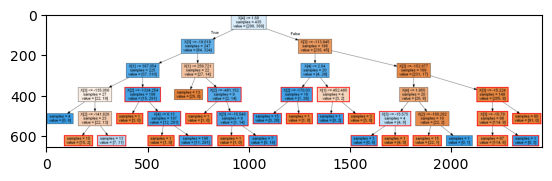

In [45]:
ind_tree = 0
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_src_h.png'))

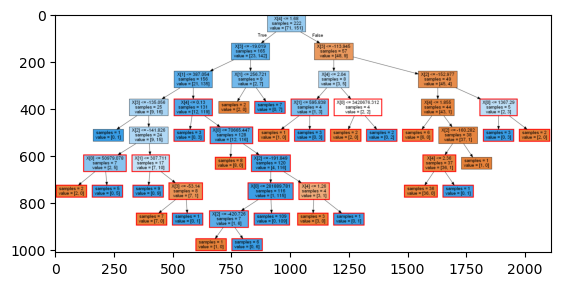

In [46]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_ser_h.png'))

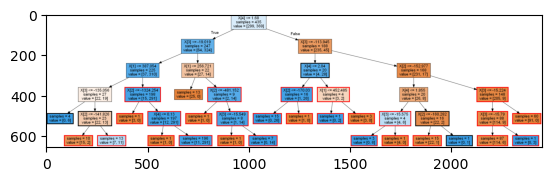

In [47]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_src_h2.png'))

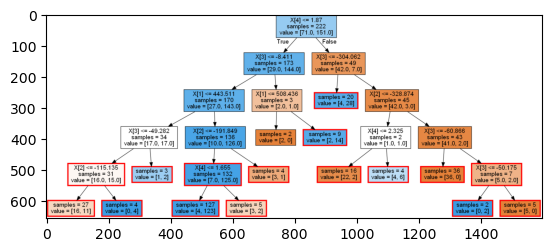

In [48]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_strut_h.png'))

<h2>Supervised random forest transfer learning on imbalanced dataset</h2><a name="imbalanced"></a>

In [49]:
path_save = ''

name_bdd_sim = 'fall_det_sim'
name_bdd_real = 'fall_det_real_imbalanced'

X_source = pd.read_csv(path_save+name_bdd_sim+'_feats.csv',dtype='float32').iloc[:,1:]
Y_source = pd.read_csv(path_save+name_bdd_sim+'_labels.csv',dtype='int32').iloc[:,1]
X_target = pd.read_csv(path_save+name_bdd_real+'_feats.csv',dtype='float32').iloc[:,1:]
Y_target = pd.read_csv(path_save+name_bdd_real+'_labels.csv',dtype='int32').iloc[:,1]

X_source = np.array(X_source)
Y_source = np.array(Y_source)
X_target = np.array(X_target)
Y_target = np.array(Y_target)

print('Target data size :',X_target.shape[0])
print('Ratio of fall events :',sum(Y_target)/Y_target.size)

Target data size : 1500
Ratio of fall events : 0.07133333333333333


In [50]:
np.random.seed(0)
DT_only = False
FEW_TRAIN = True

K_FOLD = 10
MAX = 5
RF_SIZE = 10

# Source classifier
if DT_only:
    clf_source = DecisionTreeClassifier(max_depth=MAX)
    clf_target = DecisionTreeClassifier(max_depth=MAX)
else:
    clf_source = RandomForestClassifier(n_estimators=RF_SIZE,max_depth=MAX)
    clf_target = RandomForestClassifier(n_estimators=RF_SIZE,max_depth=MAX)
    
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

auc_score_src = np.zeros(K_FOLD)
auc_score_src_tgt = np.zeros(K_FOLD)
auc_score_tgt_src = np.zeros(K_FOLD)
auc_score_tgt = np.zeros(K_FOLD)

tpr_roc_src = np.zeros(K_FOLD,dtype=object)
tpr_roc_tgt = np.zeros(K_FOLD,dtype=object)
tpr_roc_src_tgt = np.zeros(K_FOLD,dtype=object)
tpr_roc_tgt_src = np.zeros(K_FOLD,dtype=object)
fpr_roc_src = np.zeros(K_FOLD,dtype=object)
fpr_roc_tgt = np.zeros(K_FOLD,dtype=object)
fpr_roc_src_tgt = np.zeros(K_FOLD,dtype=object)
fpr_roc_tgt_src = np.zeros(K_FOLD,dtype=object)
th_roc_src = np.zeros(K_FOLD,dtype=object)
th_roc_tgt = np.zeros(K_FOLD,dtype=object)
th_roc_src_tgt = np.zeros(K_FOLD,dtype=object)
th_roc_tgt_src = np.zeros(K_FOLD,dtype=object)


k=0
for train, test in skf.split(X_source, Y_source):

    X_src_train, Y_src_train, X_src_test, Y_src_test = X_source[train], Y_source[train], X_source[test], Y_source[test]
    
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(X_target, Y_target)
    auc_score_src[k] = metr.roc_auc_score(Y_src_test,clf_source.predict_proba(X_src_test)[:,1])
    auc_score_src_tgt[k] = metr.roc_auc_score(Y_target,clf_source.predict_proba(X_target)[:,1])
    
    fpr_roc_src[k],tpr_roc_src[k],th_roc_src[k] = metr.roc_curve(Y_src_test,clf_source.predict_proba(X_src_test)[:,1])
    fpr_roc_src_tgt[k],tpr_roc_src_tgt[k],th_roc_src_tgt[k] = metr.roc_curve(Y_target,clf_source.predict_proba(X_target)[:,1])
    
    k+=1

k=0
for train, test in skf.split(X_target, Y_target):
    if FEW_TRAIN:
        X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[test], Y_target[test], X_target[train], Y_target[train]
    else:
        X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[train], Y_target[train], X_target[test], Y_target[test]

    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(X_source, Y_source)
    auc_score_tgt[k] = metr.roc_auc_score(Y_tgt_test,clf_target.predict_proba(X_tgt_test)[:,1])
    auc_score_tgt_src[k] = metr.roc_auc_score(Y_source,clf_target.predict_proba(X_source)[:,1])
    
    fpr_roc_tgt[k],tpr_roc_tgt[k],th_roc_tgt[k] = metr.roc_curve(Y_tgt_test,clf_target.predict_proba(X_tgt_test)[:,1])
    fpr_roc_tgt_src[k],tpr_roc_tgt_src[k],th_roc_tgt_src[k]  = metr.roc_curve(Y_source,clf_target.predict_proba(X_source)[:,1])
 
    k+=1
    
print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

print('ROC AUC Target model: {:.3f}'.format(np.mean(auc_score_tgt)))
print('ROC AUC Source model: {:.3f}'.format(np.mean(auc_score_src)))
print('ROC AUC Source model on Target: {:.3f}'.format(np.mean(auc_score_src_tgt)))
print('ROC AUC Target model on Source: {:.3f}'.format(np.mean(auc_score_tgt_src)))

Score Target model: 0.977
Score Source model: 0.921
Score Source model on Target: 0.917
Score Target model on Source: 0.736
ROC AUC Target model: 0.926
ROC AUC Source model: 0.962
ROC AUC Source model on Target: 0.956
ROC AUC Target model on Source: 0.882


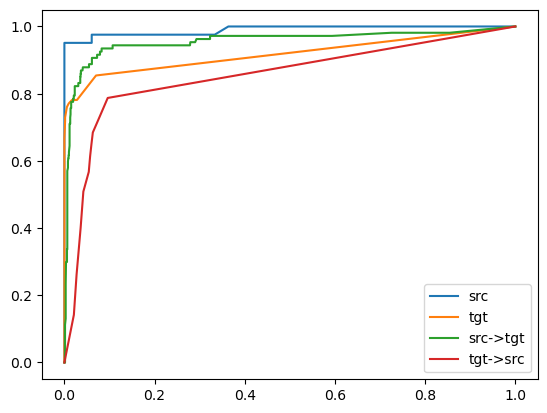

In [51]:
ind_k_fold = 5
plt.plot(fpr_roc_src[ind_k_fold],tpr_roc_src[ind_k_fold],label='src')
plt.plot(fpr_roc_tgt[ind_k_fold],tpr_roc_tgt[ind_k_fold],label='tgt')
plt.plot(fpr_roc_src_tgt[ind_k_fold],tpr_roc_src_tgt[ind_k_fold],label='src->tgt')
plt.plot(fpr_roc_tgt_src[ind_k_fold],tpr_roc_tgt_src[ind_k_fold],label='tgt->src')
plt.legend()

In [52]:
print('Mean fall leaves source : ',count_leaves(clf_source,cl=1))
print('Mean fall leaves target : ',count_leaves(clf_target,cl=1))

Mean fall leaves source :  8.1
Mean fall leaves target :  2.5


<h3>Transfer algorithms comparison and aggregation</h3><a name="comp_i"></a>

In [53]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(X_target, Y_target):
    if FEW_TRAIN:
        X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[test], Y_target[test], X_target[train], Y_target[train]
    else:
        X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[train], Y_target[train], X_target[test], Y_target[test]        

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 
        
        #print(TTS.select(X_tgt_test, Y_tgt_test))
    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test) 
         
        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 
        
        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(Y_source,TFS.STRF_model.estimator_.predict_proba(X_source)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(Y_source,strut_model.estimator_.predict_proba(X_source)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(Y_source,ser_model.estimator_.predict_proba(X_source)[:,1])
        
        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE  
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.9791111111111113
    SER 0.9775555555555554
    STRF 0.9724444444444444
AUC SCORES:
    STRUT 0.933127249784615
    SER 0.9437821761711398
    STRF 0.9617487009074385
AUC SCORES ON SRC:
    STRUT 0.8874299727600461
    SER 0.9222526927905902
    STRF 0.9615854240548616


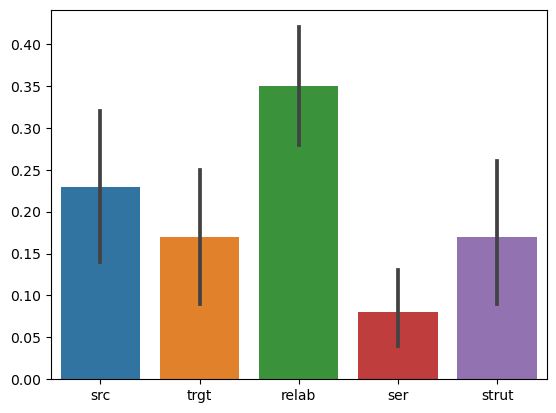

In [54]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

<h2>Transferred trees visualization</h2><a name="vis_i"></a>

In [56]:
your_path = './img/fall_det/imbalanced/'

for k in range(RF_SIZE):
    file_out = exp_draw(clf_source.estimators_[k],out_file=your_path+str(k)+'_tree_src.dot',filled=True,impurity=False)
    file_out = exp_draw(ser_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_ser.dot',filled=True,impurity=False)
    file_out = exp_draw(strut_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_strut.dot',filled=True,impurity=False)


    os.system('dot -Tpng '+your_path+str(k)+'_tree_src.dot -o '+your_path+str(k)+'_tree_src.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser.dot -o '+your_path+str(k)+'_tree_ser.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut.dot -o '+your_path+str(k)+'_tree_strut.png')

    tree_img = image.imread(your_path+str(k)+'_tree_src.png')
    tree_ser_img = image.imread(your_path+str(k)+'_tree_ser.png')
    tree_strut_img = image.imread(your_path+str(k)+'_tree_strut.png')

    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)
    T_D_ser = TreeDot(str(k)+'_tree_ser.dot',your_path)
    T_D_strut = TreeDot(str(k)+'_tree_strut.dot',your_path)

    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],ser_model.estimator_.estimators_[k],0,0)


    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated.dot')

    T_D_ser._change_color(l2,'red','color',out_file=str(k)+'_tree_ser_updated.dot')
    T_D_ser = TreeDot(str(k)+'_tree_ser_updated.dot',your_path)
    T_D_ser._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_ser_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated.dot -o '+your_path+str(k)+'_tree_src_h.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser_updated.dot -o '+your_path+str(k)+'_tree_ser_h.png')

    tree_src = image.imread(your_path+str(k)+'_tree_src_h.png')
    tree_ser = image.imread(your_path+str(k)+'_tree_ser_h.png')

    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)
    T_D_ser = TreeDot(str(k)+'_tree_ser.dot',your_path)
    T_D_strut = TreeDot(str(k)+'_tree_strut.dot',your_path)

    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],strut_model.estimator_.estimators_[k],0,0,soft=True)


    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated2.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated2.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated2.dot')

    T_D_strut._change_color(l2,'red','color',out_file=str(k)+'_tree_strut_updated.dot')
    T_D_strut = TreeDot(str(k)+'_tree_strut_updated.dot',your_path)
    T_D_strut._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_strut_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated2.dot -o '+your_path+str(k)+'_tree_src_h2.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut_updated.dot -o '+your_path+str(k)+'_tree_strut_h.png')

    tree_src2 = image.imread(your_path+str(k)+'_tree_src_h2.png')
    tree_strut = image.imread(your_path+str(k)+'_tree_strut_h.png')

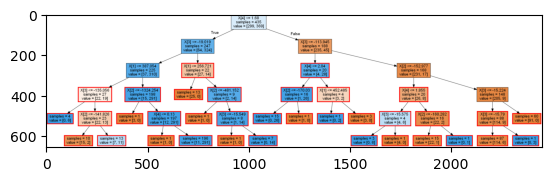

In [57]:
ind_tree = 0
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_src_h.png'))

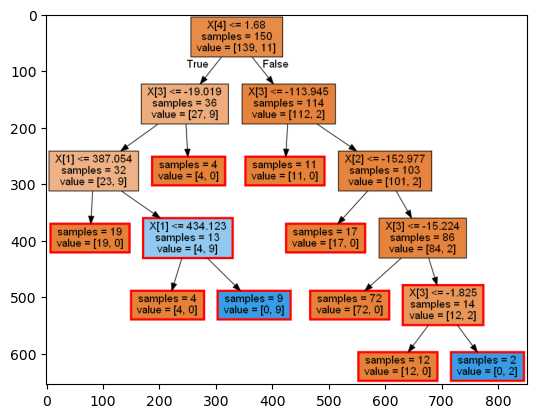

In [58]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_ser_h.png'))

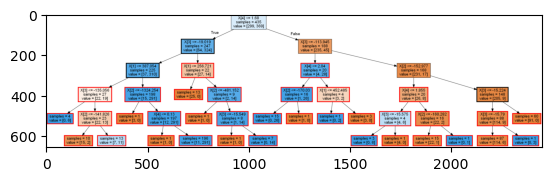

In [59]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_src_h2.png'))

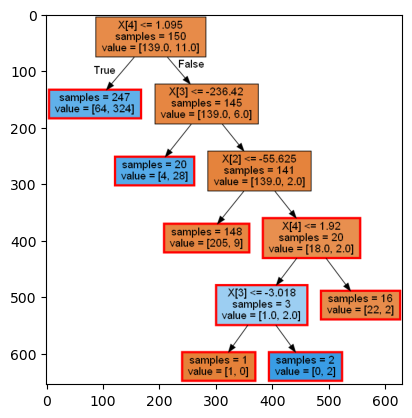

In [61]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_strut_h.png'))

<h3>Transfer algorithms adaptation for class imbalance </h3><a name="alg_imb"></a>

In [62]:
algo_list = ['src','trgt','relab','ser','strut','ser','ser','strut','strut']
#algo_list = ['ser','strut','ser','ser','strut','strut']

algo_name = ['src','trgt','relab','ser','strut','ser_noprune','ser_lambda_noprune','strut_lambda','strut_lambda_noprune']
#algo_name = ['ser','strut','ser_noprune','ser_lambda_noprune','strut_lambda','strut_lambda_noprune']

kwargs_ser_noprune = {'original_ser':False,'no_red_on_cl':True,'cl_no_red':[1]}
kwargs_ser_lambda_noprune = {'original_ser':False,'no_red_on_cl':True,'cl_no_red':[1],'leaf_loss_quantify':True,
                             'leaf_loss_threshold':0.5} 
kwargs_strut_nodiv = {'use_divergence':False}
kwargs_strut_lambda = {'adapt_prop':True}
kwargs_strut_lambda_noprune = {'adapt_prop':True,'no_prune_on_cl':True,'cl_no_prune':[1],'leaf_loss_quantify':True,
                               'leaf_loss_threshold':0.5,'no_prune_with_translation':True}

kwargs_list = [{},{},{},{},{},kwargs_ser_noprune,kwargs_ser_lambda_noprune,kwargs_strut_lambda,kwargs_strut_lambda_noprune]
#kwargs_list = [{},{},kwargs_ser_noprune,kwargs_ser_lambda_noprune,kwargs_strut_lambda,kwargs_strut_lambda_noprune]


n_versions = len(algo_list)

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

auc_score_strut_nodiv = np.zeros(K_FOLD)
auc_score_strut_lambda = np.zeros(K_FOLD)
auc_score_strut_lambda_noprune = np.zeros(K_FOLD)
auc_score_strut_nodiv_src = np.zeros(K_FOLD)
auc_score_strut_lambda_src = np.zeros(K_FOLD)
auc_score_strut_lambda_noprune_src = np.zeros(K_FOLD)

auc_score_ser_noprune = np.zeros(K_FOLD)
auc_score_ser_lambda_noprune = np.zeros(K_FOLD)
auc_score_ser_noprune_src = np.zeros(K_FOLD)
auc_score_ser_lambda_noprune_src = np.zeros(K_FOLD)


score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(X_target, Y_target):
    if FEW_TRAIN:
        X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[test], Y_target[test], X_target[train], Y_target[train]
    else:
        X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = X_target[train], Y_target[train], X_target[test], Y_target[test]

    TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list,list_alg_args=kwargs_list)
    TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
    score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test) 

    strut_model = TFS.transferred_models[algo_list.index("strut")]
    ser_model = TFS.transferred_models[algo_list.index("ser")]

    #strut_nodiv_model = TFS.transferred_models[algo_name.index("strut_nodiv")]
    strut_lambda_model = TFS.transferred_models[algo_name.index("strut_lambda")]
    strut_lambda_noprune_model = TFS.transferred_models[algo_name.index("strut_lambda_noprune")]
    
    ser_noprune_model = TFS.transferred_models[algo_name.index("ser_noprune")]
    ser_lambda_noprune_model = TFS.transferred_models[algo_name.index("ser_lambda_noprune")]
                                                       
    score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
    score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 

    auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
    auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
    auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

    auc_score_strf_src[k] = metr.roc_auc_score(Y_source,TFS.STRF_model.estimator_.predict_proba(X_source)[:,1])
    auc_score_strut_src[k] = metr.roc_auc_score(Y_source,strut_model.estimator_.predict_proba(X_source)[:,1])
    auc_score_ser_src[k] = metr.roc_auc_score(Y_source,ser_model.estimator_.predict_proba(X_source)[:,1])
    
    auc_score_ser_noprune[k] = metr.roc_auc_score(Y_tgt_test,ser_noprune_model.estimator_.predict_proba(X_tgt_test)[:,1])
    auc_score_ser_lambda_noprune[k] = metr.roc_auc_score(Y_tgt_test,ser_lambda_noprune_model.estimator_.predict_proba(X_tgt_test)[:,1])
    auc_score_ser_noprune_src[k] = metr.roc_auc_score(Y_source,ser_noprune_model.estimator_.predict_proba(X_source)[:,1])
    auc_score_ser_lambda_noprune_src[k] = metr.roc_auc_score(Y_source,ser_lambda_noprune_model.estimator_.predict_proba(X_source)[:,1])

    #auc_score_strut_nodiv[k] = metr.roc_auc_score(Y_tgt_test,strut_nodiv_model.estimator_.predict_proba(X_tgt_test)[:,1])
    auc_score_strut_lambda[k] = metr.roc_auc_score(Y_tgt_test,strut_lambda_model.estimator_.predict_proba(X_tgt_test)[:,1])    
    auc_score_strut_lambda_noprune[k] = metr.roc_auc_score(Y_tgt_test,strut_lambda_noprune_model.estimator_.predict_proba(X_tgt_test)[:,1])  
    #auc_score_strut_nodiv_src[k] = metr.roc_auc_score(Y_tgt_test,strut_nodiv_model.estimator_.predict_proba(X_tgt_test)[:,1])
    auc_score_strut_lambda_src[k] = metr.roc_auc_score(Y_source,strut_lambda_model.estimator_.predict_proba(X_source)[:,1])    
    auc_score_strut_lambda_noprune_src[k] = metr.roc_auc_score(Y_source,strut_lambda_noprune_model.estimator_.predict_proba(X_source)[:,1])  

    counts = np.zeros(n_versions)
    for u in range(n_versions):
        counts[u] = list(TFS.STRF_indexes).count(u)
    count_ind[k] = counts/RF_SIZE  
    
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
#print('    STRUT NO DIV',np.mean(auc_score_strut_nodiv))
print('    STRUT ($\lambda$)',np.mean(auc_score_strut_lambda))
print('    STRUT NO PRUNE ($\lambda$)',np.mean(auc_score_strut_lambda_noprune))
print('    SER',np.mean(auc_score_ser))
print('    SER NO PRUNE',np.mean(auc_score_ser_noprune))
print('    SER NO PRUNE($\lambda$)',np.mean(auc_score_ser_lambda_noprune))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
#print('    STRUT NO DIV',np.mean(auc_score_strut_nodiv_src))
print('    STRUT ($\lambda$)',np.mean(auc_score_strut_lambda_src))
print('    STRUT NO PRUNE ($\lambda$)',np.mean(auc_score_strut_lambda_noprune_src))
print('    SER',np.mean(auc_score_ser_src))
print('    SER NO PRUNE',np.mean(auc_score_ser_noprune_src))
print('    SER NO PRUNE($\lambda$)',np.mean(auc_score_ser_lambda_noprune_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.978
    SER 0.9771851851851853
    STRF 0.9740000000000002
AUC SCORES:
    STRUT 0.9325183903860023
    STRUT ($\lambda$) 0.9505461532169444
    STRUT NO PRUNE ($\lambda$) 0.9563450015845385
    SER 0.9448791496331405
    SER NO PRUNE 0.9502496776881092
    SER NO PRUNE($\lambda$) 0.9507936093525
    STRF 0.9583127900763003
AUC SCORES ON SRC:
    STRUT 0.8816412990007121
    STRUT ($\lambda$) 0.918658267069025
    STRUT NO PRUNE ($\lambda$) 0.9587806633038906
    SER 0.9236352489408726
    SER NO PRUNE 0.9413533337738716
    SER NO PRUNE($\lambda$) 0.9399836266584434
    STRF 0.9562578470891431


In [71]:
print('Fall leaves ser : ',count_leaves(ser_model.estimator_,cl=1))
print('Fall leaves ser no prune: ',count_leaves(ser_noprune_model.estimator_,cl=1))
print('Fall leaves ser no prune lambda: ',count_leaves(ser_lambda_noprune_model.estimator_,cl=1))
print('Fall leaves strut : ',count_leaves(strut_model.estimator_,cl=1))
print('Fall leaves strut lambda : ',count_leaves(strut_lambda_model.estimator_,cl=1))
print('Fall leaves strut no prune : ',count_leaves(strut_lambda_noprune_model.estimator_,cl=1))

Fall leaves ser :  2.3
Fall leaves ser no prune:  5.5
Fall leaves ser no prune lambda:  4.7
Fall leaves strut :  2.3
Fall leaves strut lambda :  2.6
Fall leaves strut no prune :  6.3


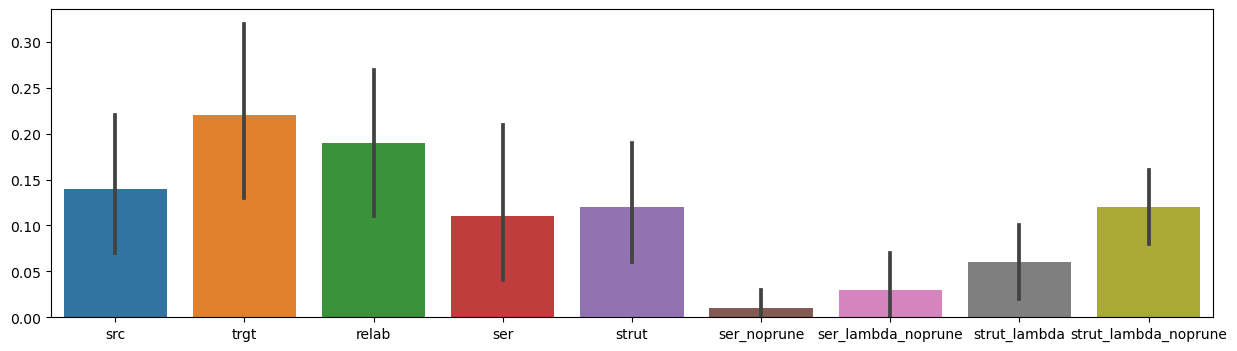

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 4))

df = pd.DataFrame(count_ind, columns = algo_name)
ax = sns.barplot(data=df)

In [83]:
your_path = './img/fall_det/imbalanced/'

for k in range(RF_SIZE):
    file_out = exp_draw(clf_source.estimators_[k],out_file=your_path+str(k)+'_tree_src.dot',filled=True,impurity=False)
    file_out = exp_draw(ser_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_ser.dot',filled=True,impurity=False)
    file_out = exp_draw(ser_noprune_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_ser_np.dot',filled=True,impurity=False)
    file_out = exp_draw(ser_lambda_noprune_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_ser_lnp.dot',filled=True,impurity=False)
    
    file_out = exp_draw(strut_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_strut.dot',filled=True,impurity=False)
    file_out = exp_draw(strut_lambda_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_strut_l.dot',filled=True,impurity=False)
    file_out = exp_draw(strut_lambda_noprune_model.estimator_.estimators_[k],out_file=your_path+str(k)+'_tree_strut_lnp.dot',filled=True,impurity=False)


    os.system('dot -Tpng '+your_path+str(k)+'_tree_src.dot -o '+your_path+str(k)+'_tree_src.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser.dot -o '+your_path+str(k)+'_tree_ser.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser_np.dot -o '+your_path+str(k)+'_tree_ser_np.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser_lnp.dot -o '+your_path+str(k)+'_tree_ser_lnp.png')
    
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut.dot -o '+your_path+str(k)+'_tree_strut.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut_l.dot -o '+your_path+str(k)+'_tree_strut_l.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut_lnp.dot -o '+your_path+str(k)+'_tree_strut_lnp.png')

    tree_img = image.imread(your_path+str(k)+'_tree_src.png')
    tree_ser_img = image.imread(your_path+str(k)+'_tree_ser.png')
    tree_ser_np_img = image.imread(your_path+str(k)+'_tree_ser_np.png')
    tree_ser_lnp_img = image.imread(your_path+str(k)+'_tree_ser_lnp.png')
    
    tree_strut_img = image.imread(your_path+str(k)+'_tree_strut.png')
    tree_strut_l_img = image.imread(your_path+str(k)+'_tree_strut_l.png')
    tree_strut_lnp_img = image.imread(your_path+str(k)+'_tree_strut_lnp.png')
    
    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)
    T_D_ser = TreeDot(str(k)+'_tree_ser.dot',your_path)
    T_D_ser_np = TreeDot(str(k)+'_tree_ser_np.dot',your_path)
    T_D_ser_lnp = TreeDot(str(k)+'_tree_ser_lnp.dot',your_path)
    
    T_D_strut = TreeDot(str(k)+'_tree_strut.dot',your_path)
    T_D_strut_l = TreeDot(str(k)+'_tree_strut_l.dot',your_path)
    T_D_strut_lnp = TreeDot(str(k)+'_tree_strut_lnp.dot',your_path)

    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],ser_model.estimator_.estimators_[k],0,0)


    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated.dot')

    T_D_ser._change_color(l2,'red','color',out_file=str(k)+'_tree_ser_updated.dot')
    T_D_ser = TreeDot(str(k)+'_tree_ser_updated.dot',your_path)
    T_D_ser._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_ser_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated.dot -o '+your_path+str(k)+'_tree_src_h.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser_updated.dot -o '+your_path+str(k)+'_tree_ser_h.png')

    tree_src = image.imread(your_path+str(k)+'_tree_src_h.png')
    tree_ser = image.imread(your_path+str(k)+'_tree_ser_h.png')
    
    ###
    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)
    
    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],strut_model.estimator_.estimators_[k],0,0,soft=True)

    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated2.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated2.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated2.dot')

    T_D_strut._change_color(l2,'red','color',out_file=str(k)+'_tree_strut_updated.dot')
    T_D_strut = TreeDot(str(k)+'_tree_strut_updated.dot',your_path)
    T_D_strut._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_strut_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated2.dot -o '+your_path+str(k)+'_tree_src_h2.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut_updated.dot -o '+your_path+str(k)+'_tree_strut_h.png')

    tree_src2 = image.imread(your_path+str(k)+'_tree_src_h2.png')
    tree_strut = image.imread(your_path+str(k)+'_tree_strut_h.png')
    
    ###
    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)

    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],ser_lambda_noprune_model.estimator_.estimators_[k],0,0)

    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated3.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated3.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated3.dot')

    T_D_ser_lnp._change_color(l2,'red','color',out_file=str(k)+'_tree_ser_lnp_updated.dot')
    T_D_ser_lnp = TreeDot(str(k)+'_tree_ser_lnp_updated.dot',your_path)
    T_D_ser_lnp._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_ser_lnp_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated3.dot -o '+your_path+str(k)+'_tree_src_h3.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_ser_lnp_updated.dot -o '+your_path+str(k)+'_tree_ser_lnp_h.png')

    tree_src3 = image.imread(your_path+str(k)+'_tree_src_h3.png')
    tree_ser_lnp = image.imread(your_path+str(k)+'_tree_ser_lnp_h.png')
    
    ###
    
    T_D_src = TreeDot(str(k)+'_tree_src.dot',your_path)
    
    l1,l2 = highlight_different_nodes(clf_source.estimators_[k],strut_lambda_noprune_model.estimator_.estimators_[k],0,0,soft=True)

    T_D_src._change_color(l1,'red','color',out_file=str(k)+'_tree_src_updated4.dot')
    T_D_src = TreeDot(str(k)+'_tree_src_updated4.dot',your_path)
    T_D_src._add_attribute(l1,'penwidth',3,out_file=str(k)+'_tree_src_updated4.dot')

    T_D_strut_lnp._change_color(l2,'red','color',out_file=str(k)+'_tree_strut_lnp_updated.dot')
    T_D_strut_lnp = TreeDot(str(k)+'_tree_strut_lnp_updated.dot',your_path)
    T_D_strut_lnp._add_attribute(l2,'penwidth',3,out_file=str(k)+'_tree_strut_lnp_updated.dot')

    os.system('dot -Tpng '+your_path+str(k)+'_tree_src_updated4.dot -o '+your_path+str(k)+'_tree_src_h4.png')
    os.system('dot -Tpng '+your_path+str(k)+'_tree_strut_lnp_updated.dot -o '+your_path+str(k)+'_tree_strut_lnp_h.png')

    tree_src4 = image.imread(your_path+str(k)+'_tree_src_h4.png')
    tree_strut_lnp = image.imread(your_path+str(k)+'_tree_strut_lnp_h.png')

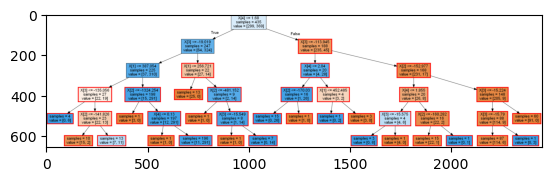

In [84]:
ind_tree = 0
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_src_h.png'))

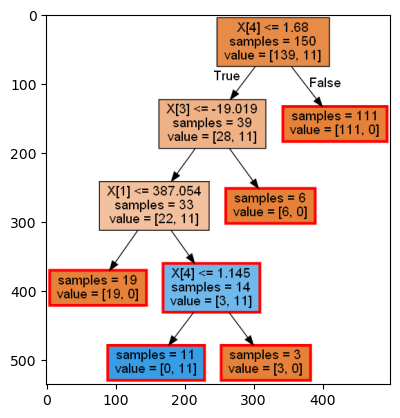

In [85]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_ser_h.png'))

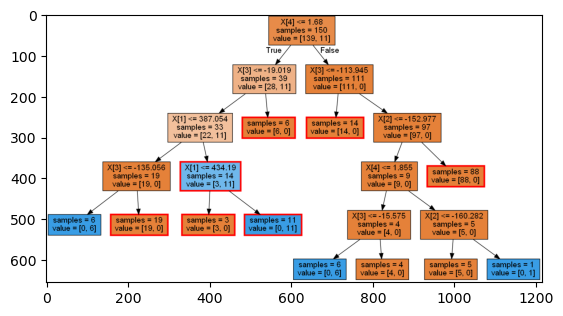

In [86]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_ser_lnp_h.png'))

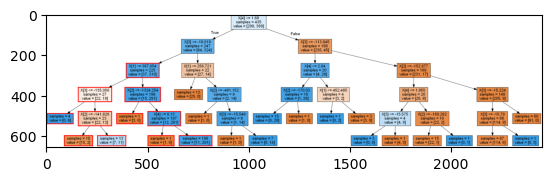

In [87]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_src_h4.png'))

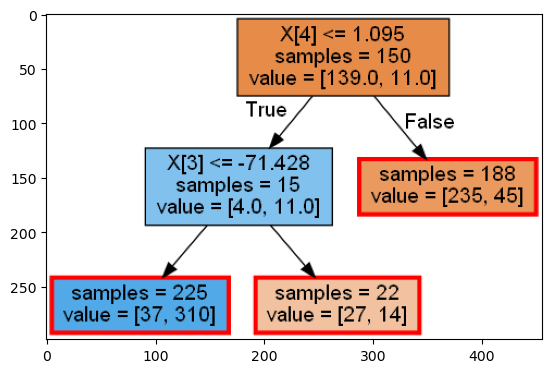

In [88]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_strut_h.png'))

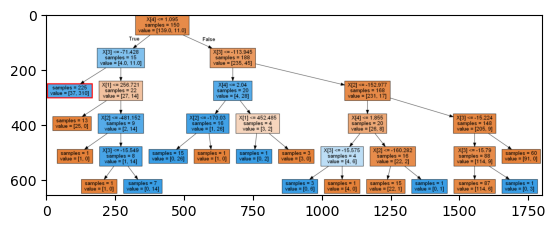

In [89]:
plt.imshow(image.imread(your_path+str(ind_tree)+'_tree_strut_lnp_h.png'))